<a href="https://colab.research.google.com/github/YunMori/YunMori/blob/main/ai_%EC%88%98%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 [==============================] - 13s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 [==============================] - 17s 17ms/step - loss: 1.8397 - accuracy: 0.3633 - val_loss: 1.3764 - val_accuracy: 0.5089
Epoch 2/100
391/391 [==============================] - 7s 17ms/step - loss: 1.4347 - accuracy: 0.4809 - val_loss: 1.2020 - val_accuracy: 0.5653
Epoch 3/100
391/391 [==============================] - 6s 16ms/step - loss: 1.2911 - accuracy: 0.5381 - val_loss: 1.1351 - val_accuracy: 0.5936
Epoch 4/100
391/391 [==============================] - 7s 18ms/step - loss: 1.1979 - accuracy: 0.5746 - val_loss: 1.0518 - val_accuracy: 0.6249
Epoch 5/100
391/391 [==============================] - 6s 16ms/step - loss: 1.1136 - accuracy: 0.6026 - val_loss: 0.9879 - val_accuracy: 0.6528
Epoch 6/100
391/391 [==============================] - 6s 16ms/step - loss: 1.0393 - accuracy: 0.6300 - val_loss: 0.9677 - val_accuracy: 0.6582
Epoch 7/100
391/391 [==============================] - 6s 16ms/step - loss: 0.9810 - accuracy: 0.6517 - val_loss: 0.9308 - val_accuracy: 0.6743
Epo

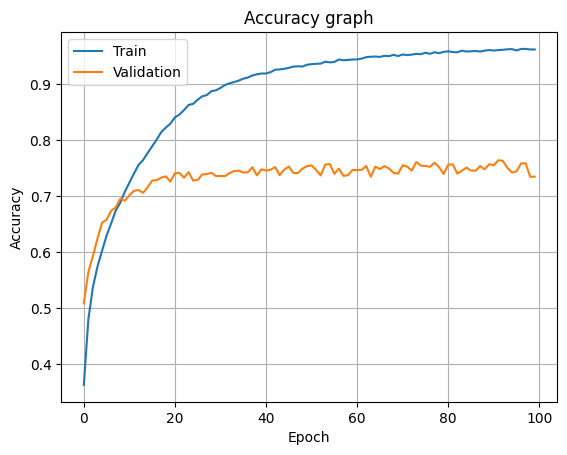

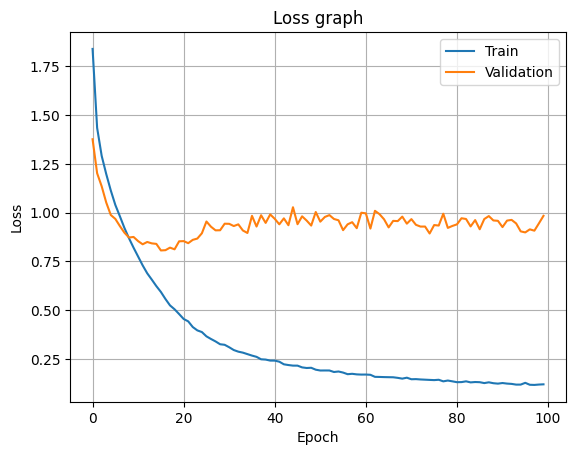

In [1]:
#11-1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

n_class=10                      # 부류 수
img_siz=(32,32,3)               # 영상의 크기

patch_siz=4                     # 패치 크기
p2=(img_siz[0]//patch_siz)**2   # 패치 개수
d_model=64                      # 임베딩 벡터 차원
h=8                             # 헤드 개수
N=6                             # 인코더 블록의 개수

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.p_siz=patch_size

    def call(self, img):
        batch_size=tf.shape(img)[0]
        patches=tf.image.extract_patches(images=img,sizes=[1,self.p_siz,self.p_siz,1],strides=[1,self.p_siz,self.p_siz,1],rates=[1,1,1,1],padding="VALID")
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self,p2,d_model): # p2: 패치 개수
        super(PatchEncoder,self).__init__()
        self.p2=p2
        self.projection=layers.Dense(units=d_model)
        self.position_embedding=layers.Embedding(input_dim=p2,output_dim=d_model)

    def call(self,patch):
        positions=tf.range(start=0,limit=self.p2,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    input=layers.Input(shape=(img_siz))
    nor=layers.Normalization()(input)
    
    patches=Patches(patch_siz)(nor)	# 패치 생성
    x=PatchEncoder(p2,d_model)(patches)	# 패치 인코딩

    for _ in range(N):			# 다중 인코더 블록
        x1=layers.LayerNormalization(epsilon=1e-6)(x)		# 층 정규화
        x2=layers.MultiHeadAttention(num_heads=h,key_dim=d_model//h,dropout=0.1)(x1,x1)			# MHA
        x3=layers.Add()([x2,x])		# 지름길 연결
        x4=layers.LayerNormalization(epsilon=1e-6)(x3)	# 층 정규화
        x5=layers.Dense(d_model*2,activation=tf.nn.gelu)(x4)
        x6=layers.Dropout(0.1)(x5)
        x7=layers.Dense(d_model,activation=tf.nn.gelu)(x6)   
        x8=layers.Dropout(0.1)(x7)        
        x=layers.Add()([x8,x3])		# 지름길 연결
    
        x=layers.LayerNormalization(epsilon=1e-6)(x)
        x=layers.Flatten()(x)
        x=layers.Dropout(0.5)(x)   
        x=layers.Dense(2048,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)
        x=layers.Dense(1024,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)    
        output=layers.Dense(n_class,activation='softmax')(x)
        
        model=keras.Model(inputs=input,outputs=output)
        return model

model=create_vit_classifier()
model.layers[1].adapt(x_train)

model.compile(optimizer=Adam(),loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
hist=model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),verbose=1)

res=model.evaluate(x_test,y_test,verbose=0)
print('정확률=',res[1]*100)

import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

Epoch 1/100
391/391 [==============================] - 23s 40ms/step - loss: 1.9997 - accuracy: 0.3260 - val_loss: 1.4729 - val_accuracy: 0.4711
Epoch 2/100
391/391 [==============================] - 16s 40ms/step - loss: 1.5624 - accuracy: 0.4392 - val_loss: 1.2575 - val_accuracy: 0.5438
Epoch 3/100
391/391 [==============================] - 16s 40ms/step - loss: 1.4328 - accuracy: 0.4887 - val_loss: 1.2078 - val_accuracy: 0.5634
Epoch 4/100
391/391 [==============================] - 15s 39ms/step - loss: 1.3524 - accuracy: 0.5174 - val_loss: 1.1063 - val_accuracy: 0.6058
Epoch 5/100
391/391 [==============================] - 15s 39ms/step - loss: 1.3039 - accuracy: 0.5406 - val_loss: 1.0905 - val_accuracy: 0.6155
Epoch 6/100
391/391 [==============================] - 16s 40ms/step - loss: 1.2477 - accuracy: 0.5598 - val_loss: 1.0273 - val_accuracy: 0.6337
Epoch 7/100
391/391 [==============================] - 16s 40ms/step - loss: 1.2009 - accuracy: 0.5792 - val_loss: 1.0748 - val_ac

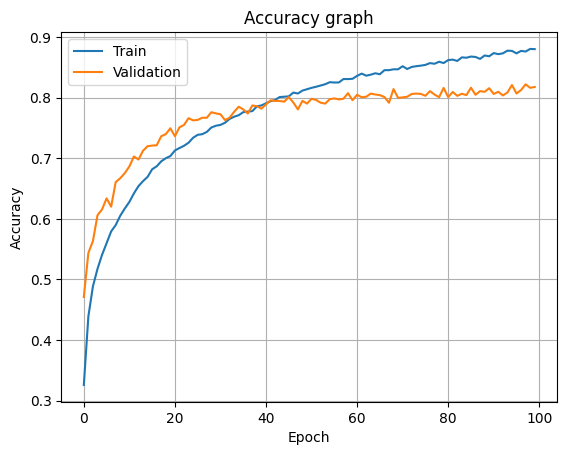

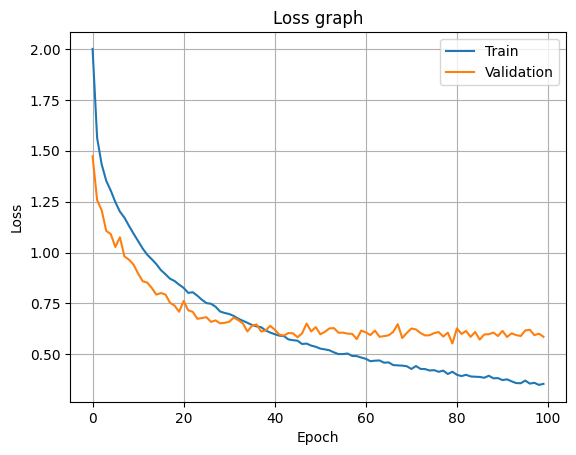

In [2]:
#11-2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

n_class=10			# 부류 수
img_siz=(32,32,3)
img_expanded_siz=(72,72,3)

patch_siz=6			# 패치 크기
p2=(img_expanded_siz[0]//patch_siz)**2 # 패치 개수
d_model=64			# 임베딩 벡터 차원
h=8				# 헤드 개수
N=6				# 인코더 블록의 개수

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.p_siz=patch_size

    def call(self, img):
        batch_size=tf.shape(img)[0]
        patches=tf.image.extract_patches(images=img,sizes=[1,self.p_siz,self.p_siz,1],strides=[1,self.p_siz,self.p_siz,1],rates=[1,1,1,1],padding="VALID")
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self,p2,d_model): # p2: 패치 개수
        super(PatchEncoder,self).__init__()
        self.p2=p2
        self.projection=layers.Dense(units=d_model)
        self.position_embedding=layers.Embedding(input_dim=p2,output_dim=d_model)

    def call(self,patch):
        positions=tf.range(start=0,limit=self.p2,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded
    
def create_vit_classifier():
    input=layers.Input(shape=(img_siz))
    nor=layers.Normalization()(input)
    exp=layers.Resizing(img_expanded_siz[0],img_expanded_siz[1])(nor)
    
    x=layers.RandomFlip('horizontal')(exp)
    x=layers.RandomRotation(factor=0.02)(x)
    x=layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)
    
    patches=Patches(patch_siz)(x)		# 패치 생성
    x=PatchEncoder(p2,d_model)(patches)	# 패치 인코딩

    for _ in range(N):			# 다중 인코더 블록
        x1=layers.LayerNormalization(epsilon=1e-6)(x)		# 층 정규화
        x2=layers.MultiHeadAttention(num_heads=h,key_dim=d_model//h,dropout=0.1)(x1,x1)			# MHA
        x3=layers.Add()([x2,x])		# 지름길 연결
        x4=layers.LayerNormalization(epsilon=1e-6)(x3)	# 층 정규화
        x5=layers.Dense(d_model*2,activation=tf.nn.gelu)(x4)
        x6=layers.Dropout(0.1)(x5)
        x7=layers.Dense(d_model,activation=tf.nn.gelu)(x6)   
        x8=layers.Dropout(0.1)(x7)        
        x=layers.Add()([x8,x3])		# 지름길 연결
    
        x=layers.LayerNormalization(epsilon=1e-6)(x)
        x=layers.Flatten()(x)
        x=layers.Dropout(0.5)(x)   
        x=layers.Dense(2048,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)
        x=layers.Dense(1024,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)    
        output=layers.Dense(n_class,activation='softmax')(x)
        
        model=keras.Model(inputs=input,outputs=output)
        return model

model=create_vit_classifier()
model.layers[1].adapt(x_train)

model.compile(optimizer=Adam(),loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
hist=model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),verbose=1)

res=model.evaluate(x_test,y_test,verbose=0)
print('정확률=',res[1]*100)

import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

    

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at google/vit-base-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


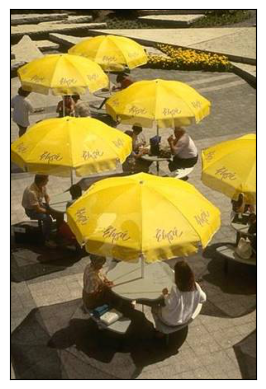

0 번째 영상의 1순위 부류:  umbrella 98.76332092285156


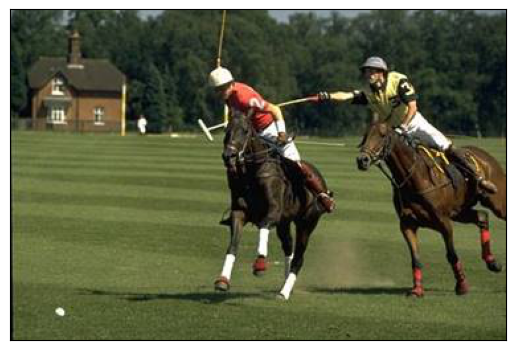

1 번째 영상의 1순위 부류:  croquet ball 3.783165693283081


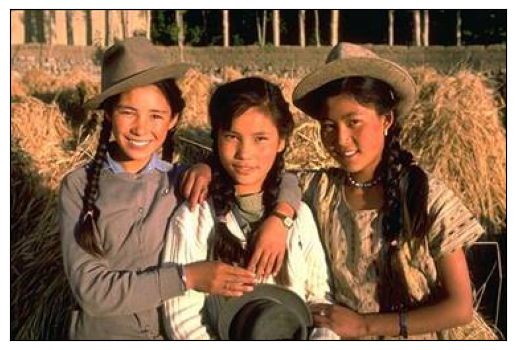

2 번째 영상의 1순위 부류:  hay 18.82138442993164


In [20]:
#11-3
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from PIL import Image
import os

img=[Image.open('BSDS_242078.jpg'),Image.open('BSDS_361010.jpg'),Image.open('BSDS_376001.jpg')]

feature_extractor=ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model=TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs=feature_extractor(img,return_tensors='tf')
res=model(**inputs)

import tensorflow as tf
import matplotlib.pyplot as plt

for i in range(res.logits.shape[0]):
    plt.imshow(img[i]); plt.xticks([]); plt.yticks([]); plt.show()
    predicted_label=int(tf.math.argmax(res.logits[i],axis=-1))
    prob=float(tf.nn.softmax(res.logits[i])[predicted_label]*100.0)
    print(i,'번째 영상의 1순위 부류: ',model.config.id2label[predicted_label],prob)

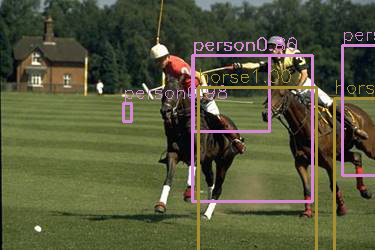

In [12]:
#11-4
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
from google.colab.patches import cv2_imshow

img=Image.open('BSDS_361010.jpg')

feature_extractor=DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model=DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

inputs=feature_extractor(img,return_tensors='pt')
res=model(**inputs)

import numpy as np
import cv2 as cv

colors=np.random.uniform(0,255,size=(100,3))	# 100개 색으로 트랙 구분
im=cv.cvtColor(np.array(img),cv.COLOR_BGR2RGB)
for i in range(res.logits.shape[1]):
    predicted_label=res.logits[0,i].argmax(-1).item() 
    if predicted_label!=91:
        name=model.config.id2label[predicted_label]
        prob='{:.2f}'.format(float(res.logits[0,i].softmax(dim=0)[predicted_label]))
        cx,cy=int(481*res.pred_boxes[0,i,0]),int(321*res.pred_boxes[0,i,1])
        w,h=int(481*res.pred_boxes[0,i,2]),int(321*res.pred_boxes[0,i,3])
        cv.rectangle(im,(cx-w//2,cy-h//2),(cx+w//2,cy+h//2),colors[predicted_label],2)
        cv.putText(im,name+str(prob),(cx-w//2,cy-h//2-5),cv.FONT_HERSHEY_SIMPLEX,0.6,colors[predicted_label],1)

cv2_imshow(im)      

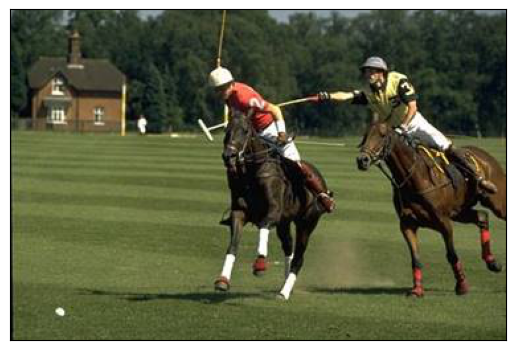

Two horses are running on grass :  9.45
Students are eating :  0.00
Croquet playing on horses :  57.47
Golf playing on horses :  33.07


In [22]:
#11-5
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

img=Image.open('BSDS_361010.jpg')

processor=CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model=CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

captions=['Two horses are running on grass', 'Students are eating', 'Croquet playing on horses', 'Golf playing on horses']
inputs=processor(text=captions,images=img,return_tensors='pt',padding=True)
res=model(**inputs)

import matplotlib.pyplot as plt
plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()

logits=res.logits_per_image
probs=logits.softmax(dim=1)
for i in range(len(captions)):
    print(captions[i],': ','{:.2f}'.format(float(probs[0,i]*100.0)))